In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics


data_train = pd.read_csv('data/data_train.csv')
data_validation = pd.read_csv('data/data_validation.csv')
data_test = pd.read_csv('data/data_test.csv')
print data_train.shape
print data_validation.shape
print data_test.shape

(304561, 215)
(152280, 215)
(152281, 215)


In [2]:
#drop unnamed column:
data_train = data_train.drop('Unnamed: 0', axis = 1)
data_validation = data_validation.drop('Unnamed: 0', axis = 1)
data_test = data_test.drop('Unnamed: 0', axis = 1)

print data_train.shape
print data_validation.shape
print data_test.shape

(304561, 214)
(152280, 214)
(152281, 214)


In [3]:
X_train = data_train.drop('Y', 1)
Y_train = data_train.Y
X_validation = data_validation.drop('Y', 1)
Y_validation = data_validation.Y
X_test = data_test.drop('Y', 1)
Y_test = data_test.Y

#merge training and validation sets for final modeling
data_train_and_validation = pd.concat([data_train, data_validation])
X_train_and_validation = data_train_and_validation.drop('Y', 1)
Y_train_and_validation = data_train_and_validation.Y

print X_train.shape
print Y_train.shape
print X_validation.shape
print Y_validation.shape
print X_test.shape
print Y_test.shape
print X_train_and_validation.shape
print Y_train_and_validation.shape

(304561, 213)
(304561,)
(152280, 213)
(152280,)
(152281, 213)
(152281,)
(456841, 213)
(456841,)


In [4]:
#OUT-OF-BOX DT

decision_tree = DecisionTreeClassifier(criterion="entropy")
decision_tree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

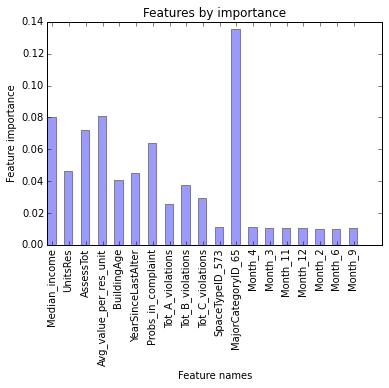

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

features = decision_tree.feature_importances_
indexes_of_important_features = np.where(features > 0.01)
features = features[indexes_of_important_features]

feature_names = X_train.columns.values[indexes_of_important_features]

index = np.arange(len(features))
rects = plt.bar(index, features, 0.5, alpha=0.4, color='b', error_kw={'ecolor': '0.3'})

plt.xlabel('Feature names')
plt.ylabel('Feature importance')
plt.title('Features by importance')
plt.xticks(index + 0.3, feature_names, rotation='vertical')

plt.show()

In [6]:
from sklearn.metrics import roc_auc_score

print "result for OUT-OF-BOX DT"
print "AUC training set %.3f." % roc_auc_score(Y_train, decision_tree.predict_proba(X_train)[:,1]) 
print "AUC validation set %.3f." % roc_auc_score(Y_validation, decision_tree.predict_proba(X_validation)[:,1])

result for OUT-OF-BOX DT
AUC training set 1.000.
AUC validation set 0.636.


In [7]:
min_samples_split_values = (np.logspace(1, 12, num=10, base=2)).astype(int)
min_samples_leaf_values = (np.logspace(1, 12, num=10, base=2)).astype(int)[::-1]

print min_samples_split_values
print min_samples_leaf_values

[   2    4   10   25   59  138  322  752 1755 4096]
[4096 1755  752  322  138   59   25   10    4    2]


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

aucs = dict()
for leaf in min_samples_leaf_values:
    aucs[leaf] = list()

#Train and calculate accuracy for each option
for leaf in min_samples_leaf_values: 
    for split in min_samples_split_values:
        decision_tree = DecisionTreeClassifier(criterion="entropy", min_samples_split=split, min_samples_leaf=leaf)
        decision_tree.fit(X_train, Y_train)
        aucs[leaf].append(roc_auc_score(Y_validation, decision_tree.predict_proba(X_validation)[:,1]))

print "DONE"    

DONE


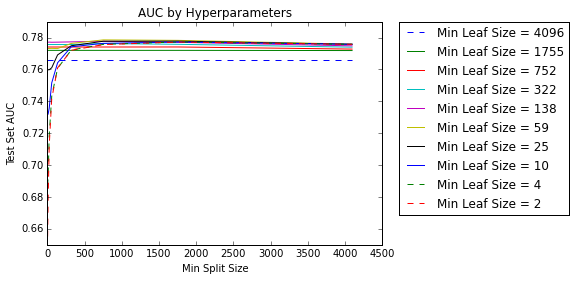

In [9]:
markers = ['b--', 'g-', 'r-', 'c-', 'm-', 'y-', 'k-', 'b-', 'g--', 'r--']

for i in range(len(markers)):
    plt.plot(min_samples_split_values, aucs[min_samples_leaf_values[i]], markers[i], label='Min Leaf Size = {}'.format(min_samples_leaf_values[i]))


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Min Split Size')
plt.ylabel('Test Set AUC')
plt.title('AUC by Hyperparameters')
plt.ylim([0.65,0.79])
plt.show()


In [10]:
#build DT based on optimal hyperparameters found above

split_opt = 2
leaf_opt = 138
decision_tree = DecisionTreeClassifier(criterion="entropy", min_samples_split=split_opt, min_samples_leaf=leaf_opt)
decision_tree.fit(X_train_and_validation, Y_train_and_validation)

print "opt hyperparam, DT, train on train+val, test on the test set"
print "AUC training_and_val set %.3f." % roc_auc_score(Y_train_and_validation, decision_tree.predict_proba(X_train_and_validation)[:,1]) 
print "AUC test set %.3f." % roc_auc_score(Y_test, decision_tree.predict_proba(X_test)[:,1])

opt hyperparam, DT, train on train+val, test on the test set
AUC training_and_val set 0.811.
AUC test set 0.778.


In [11]:
#gridSearch for DT
from sklearn import grid_search
parameters = {'min_samples_split':min_samples_split_values, 'min_samples_leaf':min_samples_leaf_values}
decision_tree = DecisionTreeClassifier(criterion="entropy")
clf_tree = grid_search.GridSearchCV(decision_tree, parameters)
clf_tree.fit(X_train_and_validation, Y_train_and_validation)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'min_samples_split': array([   2,    4,   10,   25,   59,  138,  322,  752, 1755, 4096]), 'min_samples_leaf': array([4096, 1755,  752,  322,  138,   59,   25,   10,    4,    2])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [12]:
print(clf_tree)
# summarize the results of the grid search
print(clf_tree.best_score_)
print 'min_samples_split', (clf_tree.best_estimator_.min_samples_split)
print 'min_samples_leaf', (clf_tree.best_estimator_.min_samples_leaf)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'min_samples_split': array([   2,    4,   10,   25,   59,  138,  322,  752, 1755, 4096]), 'min_samples_leaf': array([4096, 1755,  752,  322,  138,   59,   25,   10,    4,    2])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)
0.809957950359
min_samples_split 752
min_samples_leaf 322


In [14]:
split_tree = clf_tree.best_estimator_.min_samples_split
leaf_tree = clf_tree.best_estimator_.min_samples_leaf
tree_final = DecisionTreeClassifier(criterion="entropy", min_samples_split=split_tree, min_samples_leaf=leaf_tree)
tree_final.fit(X_train_and_validation, Y_train_and_validation)  

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=322,
            min_samples_split=752, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [15]:
print "DT, hyperpar found with GridSearch, train on train+val, test on the test set"
print "AUC training_and_validation set %.3f." % roc_auc_score(Y_train_and_validation, tree_final.predict_proba(X_train_and_validation)[:,1]) 
print "AUC test set %.3f." % roc_auc_score(Y_test, tree_final.predict_proba(X_test)[:,1])

DT, hyperpar found with GridSearch, train on train+val, test on the test set
AUC training_and_validation set 0.794.
AUC test set 0.777.


In [ ]:
#RANDOM FOREST

In [16]:
#out-of-box random forest

from sklearn.ensemble import RandomForestClassifier 

# n_estimators: number of trees in the forest.
forest = RandomForestClassifier(n_estimators = 100, criterion = "entropy")
forest = forest.fit(X_train,Y_train)

In [17]:
print "out-of-box random forest"
print "AUC training set %.3f." % roc_auc_score(Y_train, forest.predict_proba(X_train)[:,1]) 
print "AUC validation set %.3f." % roc_auc_score(Y_validation, forest.predict_proba(X_validation)[:,1])

out-of-box random forest
AUC training set 0.999.
AUC validation set 0.803.


In [18]:
#gridSearch to find optimal hyperparameters
min_samples_split_values = (np.logspace(1, 12, num=10, base=2)).astype(int)
min_samples_leaf_values = (np.logspace(1, 12, num=10, base=2)).astype(int)[::-1]
n_estimators_max = [10, 100, 150]
parameters = {'n_estimators': n_estimators_max, 'min_samples_split':min_samples_split_values, 'min_samples_leaf':min_samples_leaf_values}

forest = RandomForestClassifier(criterion="entropy")
clf_forest = grid_search.GridSearchCV(forest, parameters, scoring = "roc_auc")
clf_forest.fit(X_train_and_validation, Y_train_and_validation)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_estimators': [10, 100, 150], 'min_samples_split': array([   2,    4,   10,   25,   59,  138,  322,  752, 1755, 4096]), 'min_samples_leaf': array([4096, 1755,  752,  322,  138,   59,   25,   10,    4,    2])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=0)

In [20]:
print(clf_forest)
# summarize the results of the grid search
print(clf_forest.best_score_)
print 'min_samples_split', (clf_forest.best_estimator_.min_samples_split)
print 'min_samples_leaf', (clf_forest.best_estimator_.min_samples_leaf)
print 'number of trees in the forest', (clf_forest.best_estimator_.n_estimators)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_estimators': [10, 100, 150], 'min_samples_split': array([   2,    4,   10,   25,   59,  138,  322,  752, 1755, 4096]), 'min_samples_leaf': array([4096, 1755,  752,  322,  138,   59,   25,   10,    4,    2])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=0)
0.807837805025
min_samples_split 4
min_samples_leaf 2
number of trees in the forest 150


In [21]:
split_forest = clf_forest.best_estimator_.min_samples_split
leaf_forest = clf_forest.best_estimator_.min_samples_leaf
n_of_trees = clf_forest.best_estimator_.n_estimators
forest_final = RandomForestClassifier(n_estimators = n_of_trees, criterion="entropy", min_samples_split=split_forest, min_samples_leaf=leaf_forest)
forest_final.fit(X_train_and_validation, Y_train_and_validation)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
print "AUC training_and_validation set %.3f." % roc_auc_score(Y_train_and_validation, forest_final.predict_proba(X_train_and_validation)[:,1]) 
print "AUC test set %.3f." % roc_auc_score(Y_test, forest_final.predict_proba(X_test)[:,1])

AUC training_and_validation set 0.989.
AUC test set 0.812.


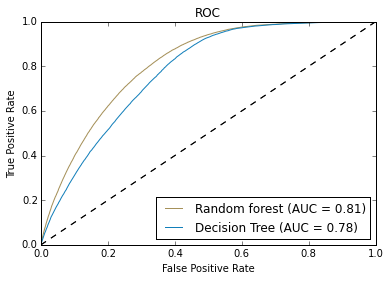

In [23]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, datasets, svm
from sklearn.metrics import roc_auc_score, auc, roc_curve

def plot_ROC(y_true, y_predicted, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_predicted)
    roc_auc = auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c, label = model_name+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")

plot_ROC(Y_test, forest_final.predict_proba(X_test)[:,1], 'Random forest')
plot_ROC(Y_test, tree_final.predict_proba(X_test)[:,1], 'Decision Tree')
plt.show()